## 255 - Calculating Q-Vectors to Find Frontogenic and Frontolytic Zones

[Youtube](https://www.youtube.com/watch?v=wdsc2uaTMuc)

In [1]:
import pandas as pd
import metpy.calc as mpcalc
import matplotlib.pyplot as plt
from metpy.units import units
from metpy.interpolate import interpolate_to_grid

In [2]:
data_fname = 'https://www.mesonet.org/data/public/mesonet/mdf/2011/11/02/201111022025.mdf'
loc_fname = 'https://www.mesonet.org/index.php/api/siteinfo/from_all_active_with_geo_fields/format/csv'

In [3]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import numpy as np
from metpy.plots import add_metpy_logo, USCOUNTIES

In [4]:
df = pd.read_csv(data_fname, skiprows = 2, delim_whitespace = True)

df = df[['STID', 'TAIR', 'WSPD', 'WDIR', 'PRES']]

df_loc = pd.read_csv(loc_fname)

df_loc = df_loc[['stid', 'nlat', 'elon']]

df_merged = pd.merge(df, df_loc, left_on = 'STID', right_on = 'stid')

df_merged.drop('stid', axis = 1, inplace = True)
df_merged.head()

,STID,TAIR,WSPD,WDIR,PRES,nlat,elon
0,ADAX,19.8,5.2,193,977.97,34.79851,-96.66909
1,ALTU,10.6,13.5,325,970.72,34.58722,-99.33808
2,ARNE,3.1,10.9,340,938.03,36.07204,-99.90308
3,BEAV,1.6,11.2,339,935.84,36.80253,-100.53012
4,BESS,7.5,12.6,322,958.58,35.40185,-99.05847


In [5]:
df_merged['U'], df_merged['V'] = mpcalc.wind_components(df_merged['WSPD'].values * units('m/s'), df_merged['WDIR'].values * units.degrees)
 
gridx, gridy, grid_temperature = interpolate_to_grid(df_merged['elon'].values, df_merged['nlat'].values, df_merged['TAIR'].values, interp_type = 'cressman', minimum_neighbors = 1, search_radius = 0.5, hres = 0.1)

gridx, gridy, grid_pressure = interpolate_to_grid(df_merged['elon'].values, df_merged['nlat'].values, df_merged['PRES'].values, interp_type = 'cressman', minimum_neighbors = 1, search_radius = 0.5, hres = 0.1)

gridx, gridy, grid_u = interpolate_to_grid(df_merged['elon'].values, df_merged['nlat'].values, df_merged['U'].values, interp_type = 'cressman', minimum_neighbors = 1, search_radius = 0.5, hres = 0.1)

gridx, gridy, grid_v = interpolate_to_grid(df_merged['elon'].values, df_merged['nlat'].values, df_merged['V'].values, interp_type = 'cressman', minimum_neighbors = 1, search_radius = 0.5, hres = 0.1)

In [6]:
crs = ccrs.LambertConformal(central_longitude = -100, central_latitude = 45)
data_crs = ccrs.PlateCarree()
clevels = np.arange(0, 28, 1)

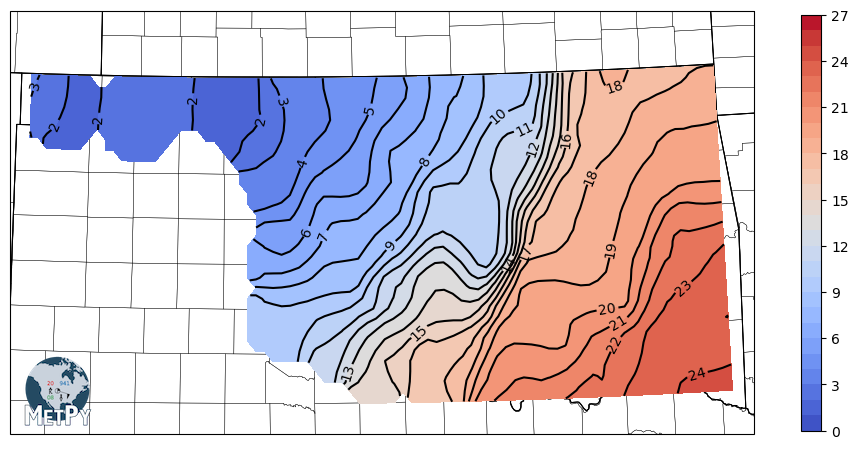

In [7]:
fig = plt.figure(figsize = (12, 9))
add_metpy_logo(fig, 20, 20, size = 'small')

ax = fig.add_subplot(1, 1, 1, projection = crs)
ax.set_extent((-103, -94.4, 33.5, 37.5), crs = data_crs)
ax.add_feature(cfeature.STATES, linewidth = 0.75)
ax.add_feature(USCOUNTIES.with_scale('5m'), linewidth = 0.25)

c = ax.contourf(gridx, gridy, grid_temperature, transform = ccrs.PlateCarree(), cmap = 'coolwarm', levels = clevels)

c1 = ax.contour(gridx, gridy, grid_temperature, transform = ccrs.PlateCarree(), colors = 'k', levels = clevels)

ax.clabel(c1, inline = True, fontsize = 10)

plt.colorbar(c, shrink = 0.6)

temperature_gradient = mpcalc.gradient(grid_temperature, deltas = (0.1, 0.1))

plt.scatter(gridx, gridy, c = temperature_gradient[0])

plt.scatter(gridx, gridy, c = temperature_gradient[1])

gradient_m = np.sqrt(temperature_gradient[0]**2 + temperature_gradient[1]**2)
plt.scatter(gridx, gridy, c = gradient_m)

In [8]:
q_vectors = mpcalc.q_vector(grid_u * units('m/s'), grid_v * units('m/s'), grid_temperature * units('degC'), grid_pressure * units('hPa'), 11.1 * units.km, 11.1 * units.km)

q_vectors_u = q_vectors[0].m
q_vectors_v = q_vectors[1].m

q_vectors_u

array([[            nan,             nan,             nan, ...,
        -1.15369618e-12, -1.25189442e-12, -1.02139888e-12],
       [            nan,             nan,             nan, ...,
        -1.03900603e-12, -1.16739035e-12, -1.24022786e-12],
       [            nan,             nan,             nan, ...,
        -9.43874775e-13, -1.09562072e-12, -1.21934903e-12],
       ...,
       [ 1.24732303e-12,  1.33048219e-12,  1.37181926e-12, ...,
        -7.38773271e-13, -6.22456555e-13,  1.65150917e-13],
       [ 1.35553640e-12,  1.38139472e-12,  1.44983318e-12, ...,
        -4.43902523e-13, -2.25048852e-13,  6.46873669e-13],
       [ 1.92670014e-12,  1.70026972e-12,  1.70559069e-12, ...,
        -3.39618807e-14, -3.66899951e-14,  4.45428107e-14]])

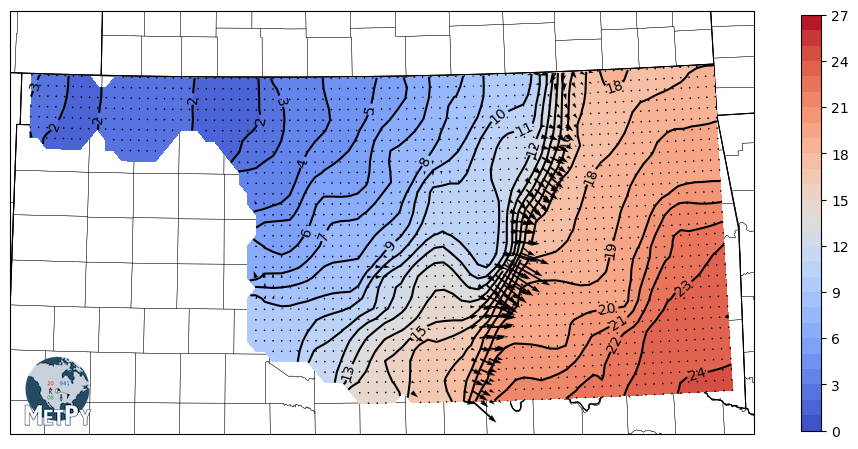

In [9]:
fig = plt.figure(figsize = (12, 9))
add_metpy_logo(fig, 20, 20, size = 'small')

ax = fig.add_subplot(1, 1, 1, projection = crs)
ax.set_extent((-103, -94.4, 33.5, 37.5), crs = data_crs)
ax.add_feature(cfeature.STATES, linewidth = 0.75)
ax.add_feature(USCOUNTIES.with_scale('5m'), linewidth = 0.25)

c = ax.contourf(gridx, gridy, grid_temperature, transform = ccrs.PlateCarree(), cmap = 'coolwarm', levels = clevels)

c1 = ax.contour(gridx, gridy, grid_temperature, transform = ccrs.PlateCarree(), colors = 'k', levels = clevels)

ax.clabel(c1, inline = True, fontsize = 10)

ax.quiver(gridx, gridy, q_vectors_u, q_vectors_v, transform = data_crs, scale = 3e-9)

plt.colorbar(c, shrink = 0.6)

temperature_gradient = mpcalc.gradient(grid_temperature, deltas = (0.1, 0.1))

plt.scatter(gridx, gridy, c = temperature_gradient[0])

plt.scatter(gridx, gridy, c = temperature_gradient[1])

gradient_m = np.sqrt(temperature_gradient[0]**2 + temperature_gradient[1]**2)
plt.scatter(gridx, gridy, c = gradient_m)